     C1   C2   C3   C4   C5
C1   NA 0.67 0.95 0.66 0.55
C2 0.31   NA 0.87 0.49 0.32
C3 0.05 0.11   NA 0.11 0.03
C4 0.32 0.49 0.88   NA 0.32
C5 0.42 0.66 0.97 0.65   NA


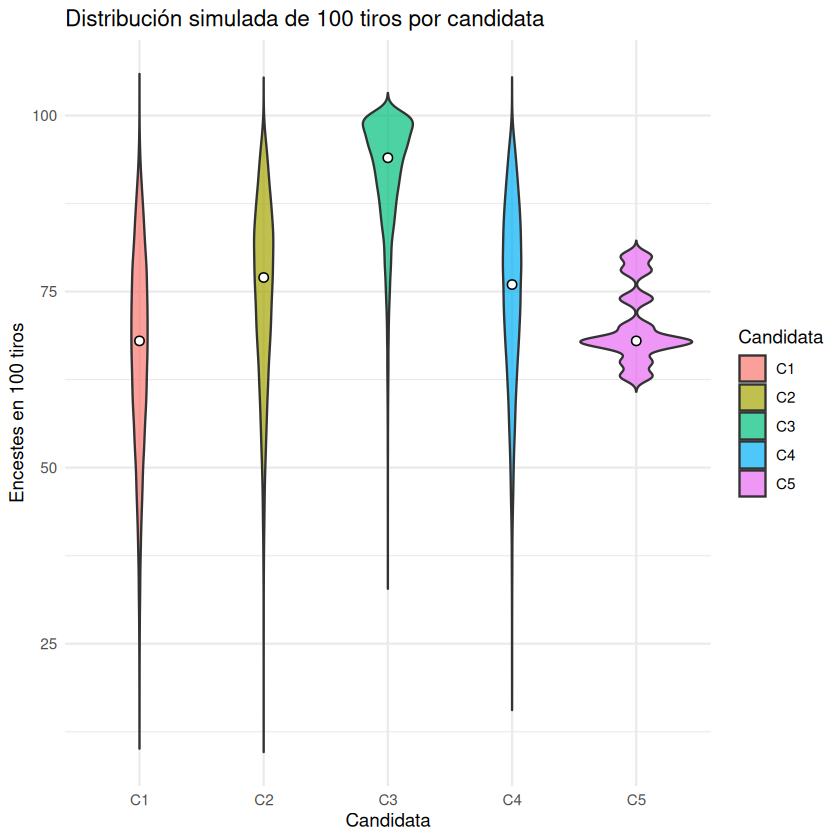

In [4]:
set.seed(123)

library(ggplot2)
library(tidyr)
library(dplyr)
library(rstanarm)

# Datos observados: tiros de jugadoras por pueblo (supuestos)
datos_jugadoras <- data.frame(
  Pueblo = rep(paste0("C", 1:4), times = c(10, 20, 30, 40)),
  Aciertos = c(
    rbinom(10, 10, 0.6),
    rbinom(20, 10, 0.6),
    rbinom(30, 10, 0.6),
    rbinom(40, 10, 0.6)
  ),
  Total = 10
)

datos_jugadoras$Fallo <- datos_jugadoras$Total - datos_jugadoras$Aciertos

# Modelo jerárquico bayesiano: habilidad ~ pueblo con random effect
modelo <- stan_glmer(cbind(Aciertos, Fallo) ~ 1 + (1 | Pueblo), 
                     data = datos_jugadoras, 
                     family = binomial(), 
                     prior = normal(0, 1), 
                     prior_intercept = normal(0, 1), 
                     chains = 2, iter = 2000, refresh = 0)

# Extraer efectos aleatorios por pueblo
posterior <- as.data.frame(posterior_linpred(modelo, transform = TRUE, re.form = ~ (1 | Pueblo)))

# Seleccionamos la jugadora con más aciertos por pueblo y usamos el posterior correspondiente
mejores <- datos_jugadoras %>% group_by(Pueblo) %>% slice_max(Aciertos, with_ties = FALSE)

# Extraemos muestras del parámetro p de cada mejor jugadora por pueblo
p1 <- posterior[["(Intercept)"]] + ranef(modelo)$Pueblo["C1", 1]
p2 <- posterior[["(Intercept)"]] + ranef(modelo)$Pueblo["C2", 1]
p3 <- posterior[["(Intercept)"]] + ranef(modelo)$Pueblo["C3", 1]
p4 <- posterior[["(Intercept)"]] + ranef(modelo)$Pueblo["C4", 1]

# Logit a probabilidad
inv_logit <- function(x) 1 / (1 + exp(-x))
p1 <- inv_logit(p1)
p2 <- inv_logit(p2)
p3 <- inv_logit(p3)
p4 <- inv_logit(p4)

# C5: distribución empírica basada en 10 rondas reales de la misma persona
c5_rounds <- c(68, 74, 78, 70, 68, 63, 80, 68, 67, 65)

# Simulamos 10000 rondas de 100 tiros para cada candidata
test_c1 <- rbinom(10000, 100, sample(p1, 10000, replace = TRUE))
test_c2 <- rbinom(10000, 100, sample(p2, 10000, replace = TRUE))
test_c3 <- rbinom(10000, 100, sample(p3, 10000, replace = TRUE))
test_c4 <- rbinom(10000, 100, sample(p4, 10000, replace = TRUE))
test_c5 <- sample(c5_rounds, 10000, replace = TRUE)

simulaciones <- data.frame(C1 = test_c1, C2 = test_c2, C3 = test_c3, C4 = test_c4, C5 = test_c5)

# Matriz de comparación
prob_menor <- function(x, y) mean(x < y)
candidatas <- names(simulaciones)
comparaciones <- matrix(NA, 5, 5, dimnames = list(candidatas, candidatas))
for (i in candidatas) {
  for (j in candidatas) {
    if (i != j) {
      comparaciones[i, j] <- prob_menor(simulaciones[[i]], simulaciones[[j]])
    }
  }
}

print(round(comparaciones, 2))

# Violin plot de distribuciones
simulaciones_long <- pivot_longer(simulaciones, cols = everything(), names_to = "Candidata", values_to = "Encestes")

ggplot(simulaciones_long, aes(x = Candidata, y = Encestes, fill = Candidata)) +
  geom_violin(trim = FALSE, alpha = 0.7) +
  stat_summary(fun = median, geom = "point", shape = 21, size = 2, fill = "white") +
  theme_minimal() +
  labs(title = "Distribución simulada de encestes en 100 tiros por candidata",
       y = "Encestes en 100 tiros", x = "Candidata")